In [1]:
import numpy as np
from numpy.typing import ArrayLike
import matplotlib.pyplot as plt

## define PSF

In [2]:
def R_lambda(q_obs, q_mod, lambda_ratio_list, w_lambda, mu_q):
    r"""
    Constructs the full polychromatic point-spread function R(q, q') such that

        I_obs(q) = ∫ R(q, q') I_mod(q') dq'  ≈  (R @ I_mod)(q)

    Parameters
    ----------
    q_obs : (M_obs,) ndarray
        Q-values where the observed intensity I_obs(q) is evaluated.
    q_mod : (M_mod,) ndarray
        Q'-values defining the latent/model intensity I_mod(q').
    lambda_ratio_list : (N,) ndarray
        Ratios ρ_i = λ_i / λ_0 for each wavelength component.
    w_lambda : (N,) ndarray
        Normalized spectral weights (∑ w_lambda = 1).
    mu_q : float
        Gaussian width (in Q-units) controlling the mapping spread from q_mod → q_obs.

        - Small mu_q  → narrow PSF, nearly δ(q−ρq′)
        - Large mu_q  → broad smearing, stronger convolution

    Returns
    -------
    R : (M_obs, M_mod) ndarray
        Discrete kernel approximating R(q, q') including wavelength distribution.

    Notes
    -----
    Implements:
        R(q,q') = Σ_i w_i · [ exp(−(q − ρ_i q')² / (2 μ_q²)) / Z_i(q') ]
    where Z_i(q') ensures ∫ R(q,q') dq = 1 for each q'.

    --------------------------------------------------------------------------
    LaTeX source 
    --------------------------------------------------------------------------
    \begin{equation}
        R(q,q')
        \;=\;
        \sum_{i} w_i \,
        \frac{
            \exp\!\left[-\dfrac{(q - \rho_i q')^2}{2\,\mu_q^2}\right]
        }{
            Z_i(q')
        },
        \qquad
        Z_i(q')
        \;=\;
        \int_{-\infty}^{\infty}
        \exp\!\left[-\dfrac{(q - \rho_i q')^2}{2\,\mu_q^2}\right]
        \mathrm{d}q.
        \label{eq:R_q_def}
    \end{equation}
    --------------------------------------------------------------------------
    """
    q_obs = np.asarray(q_obs)
    q_mod = np.asarray(q_mod)
    lambda_ratio_list = np.asarray(lambda_ratio_list)
    w_lambda = np.asarray(w_lambda)

    M_obs, M_mod = q_obs.size, q_mod.size
    R = np.zeros((M_obs, M_mod), dtype=float)

    # --- Implements: R(q, q') = Σ_i w_i * exp[-(q - ρ_i q')² / (2 μ_q²)] / Z_i(q') ---
    for rho, w_i in zip(lambda_ratio_list, w_lambda):
        q_center = rho * q_mod[None, :]           # Shift q' → ρ_i q'
        diff = q_obs[:, None] - q_center          # (M_obs, M_mod)
        phi = np.exp(-0.5 * (diff / mu_q) ** 2)

        # Normalize over q_obs for each q' (column-wise)
        Z_i = phi.sum(axis=0, keepdims=True)
        Z_i[Z_i == 0] = 1.0
        phi /= Z_i

        # Weighted sum over wavelength components
        R += w_i * phi

    return R

In [3]:
# -----------------------------------------------------------------------------
# Utilities
# -----------------------------------------------------------------------------

def _ensure_1d(a: ArrayLike) -> np.ndarray:
    a = np.asarray(a, dtype=float)
    if a.ndim != 1:
        raise ValueError("Input arrays must be 1D")
    return a


def _gauss_legendre_ab(a: float, b: float, n: int) -> tuple[np.ndarray, np.ndarray]:
    """Return Gauss–Legendre nodes x and weights w mapped to [a, b]."""
    t, w = np.polynomial.legendre.leggauss(n)
    # map from [-1,1] to [a,b]
    x = 0.5 * (b - a) * t + 0.5 * (a + b)
    w = 0.5 * (b - a) * w
    return x, w


def _gaussian_smoother(Q_mod: np.ndarray, mu_Q: float) -> np.ndarray:
    """Row-normalized Gaussian kernel S over Q_mod with std=mu_Q.

    S has shape (M_mod, M_mod) and rows sum to 1. Applying smoothing to a kernel
    R (M_obs, M_mod) is done as: R_smoothed = R @ S.T
    """
    if mu_Q <= 0:
        return None  # sentinel for no smoothing
    Q = Q_mod[:, None]
    d2 = (Q - Q.T) ** 2
    # Add a tiny epsilon in case mu_Q is extremely small to avoid over/underflow
    eps = 1e-30
    S = np.exp(-0.5 * d2 / max(mu_Q * mu_Q, eps))
    # Row-normalize
    row_sum = S.sum(axis=1, keepdims=True)
    # Avoid division by zero on pathological inputs
    row_sum[row_sum == 0] = 1.0
    S /= row_sum
    return S


def renormalize_rows(R: np.ndarray, Q_mod: np.ndarray) -> np.ndarray:
    """Renormalize rows of R so that \int R(Qx_i, Q') dQ' ≈ 1 numerically.

    Parameters
    ----------
    R : (M_obs, M_mod) array
    Q_mod : (M_mod,) grid for Q'
    """
    Q_mod = _ensure_1d(Q_mod)
    if R.ndim != 2 or R.shape[1] != Q_mod.size:
        raise ValueError("R must be 2D with second dimension equal to len(Q_mod)")
    # Numerical integral over Q'
    integ = np.trapz(R, Q_mod, axis=1)
    # Prevent divide-by-zero; rows with zero integral remain zero
    scale = np.ones_like(integ)
    nz = np.abs(integ) > 0
    scale[nz] = 1.0 / integ[nz]
    return (R.T * scale).T


# -----------------------------------------------------------------------------
# 1) Vertical slit kernel
# -----------------------------------------------------------------------------

def R_slit(Qx_obs: ArrayLike, Q_mod: ArrayLike, sigma_y: float, mu_Q: float = 0.0) -> np.ndarray:
    r"""
    Discrete slit-averaged PSF R_slit(Q_x, Q') for

        I_exp(Q_x) = (1/(2 σ_y)) ∫_{-σ_y}^{σ_y} I( sqrt(Q_x^2 + Q_y^2) ) dQ_y
                    = ∫ R_slit(Q_x, Q') I(Q') dQ'.

    Implements the analytical kernel

        R_slit(Q_x, Q') = { (1/σ_y) * Q' / sqrt(Q'^2 − Q_x^2),
                             if Q_x ≤ Q' ≤ sqrt(Q_x^2 + σ_y^2);
                             0 otherwise }.

    Parameters
    ----------
    Qx_obs : (M_obs,) array
        Positions where I_exp(Qx) is evaluated (assume Qx_obs > 0).
    Q_mod : (M_mod,) array
        Radial grid Q' where I(Q') is defined.
    sigma_y : float
        Half-width of the vertical slit (in Q_y units).
    mu_Q : float, optional
        Std of Gaussian smoothing along Q' to stabilize coarse sampling.

    Returns
    -------
    R : (M_obs, M_mod) array
        Kernel such that I_exp ≈ R @ I_mod.
    """
    Qx = _ensure_1d(Qx_obs)
    Qp = _ensure_1d(Q_mod)
    if sigma_y <= 0:
        raise ValueError("sigma_y must be positive")

    # Broadcasted computation over (M_obs, M_mod)
    Qx_mat = Qx[:, None]      # (M_obs, 1)
    Qp_row = Qp[None, :]      # (1, M_mod)

    # Support and unregularized denom
    support = (Qp_row >= Qx_mat) & (Qp_row <= np.sqrt(Qx_mat**2 + sigma_y**2))

    # Grid-dependent regularization scale for the singularity
    # if Qp.size > 1:
    #     dQ_min = np.min(np.diff(Qp))
    #     eps = 0.5 * dQ_min
    # else:
    #     eps = 1e-12  # fallback if only one point
    eps = 1e-15
    # Regularized denominator: sqrt(Q'^2 - Q_x^2 + eps^2)
    denom_sq = Qp_row**2 - Qx_mat**2
    denom_reg = np.sqrt(np.maximum(denom_sq, 0.0) + eps**2)

    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = Qp_row / denom_reg
        base = np.where(support, (1.0 / sigma_y) * ratio, 0.0)

    R = base

    # Optional smoothing along Q' (right-multiply by S^T)
    S = _gaussian_smoother(Qp, mu_Q)
    if S is not None:
        R = R @ S.T

    # Renormalize rows to conserve intensity numerically
    # R = renormalize_rows(R, Qp)
    return R

# -----------------------------------------------------------------------------
# 2) Rectangular pinhole: average of slit kernels across Qx' ∈ [Qx-σx, Qx+σx]
# -----------------------------------------------------------------------------

def R_rect(
    Qx_obs: ArrayLike,
    Q_mod: ArrayLike,
    sigma_x: float,
    sigma_y: float,
    *,
    nx: int = 64,
    mu_Q: float = 0.0,
    cell_average: bool = True,
    quad: str = "gauss",
) -> np.ndarray:
    r"""
    Rectangular pinhole PSF via horizontal averaging of slit PSFs:

        R_rect(Qx, Q') = (1/(2 σ_x)) ∫_{Qx-σ_x}^{Qx+σ_x} R_slit(Qx', Q'; σ_y) dQx'.

    The outer integral over Qx' can be evaluated either by Gauss–Legendre
    quadrature (default) or by a simple trapezoidal rule over a uniform grid:

    - quad = "gauss": use Legendre nodes mapped to [Qx-σ_x, Qx+σ_x] with `nx` nodes.
    - quad = "trapz": use uniform nodes and np.trapz along Qx'.

    Parameters
    ----------
    Qx_obs : (M_obs,) array
        Observed Q_x positions.
    Q_mod  : (M_mod,) array
        Radial Q' grid where I(Q') is defined.
    sigma_x : float
        Horizontal half-width of the rectangle.
    sigma_y : float
        Vertical half-width of the rectangle (slit half-width).
    nx : int, optional
        Number of nodes for the outer integral over Qx'.
    mu_Q : float, optional
        Std of Gaussian smoothing along Q' to stabilize coarse sampling.
    cell_average : bool, optional
        If True, use analytic bin-averaged slit kernel over each Q' bin to avoid
        the integrable singularity at Q' = Qx'. If False, uses pointwise formula.
    quad : {"gauss", "trapz"}, optional
        Quadrature rule for the outer integral over Qx'.

    Returns
    -------
    R : (M_obs, M_mod) array
        Rectangular PSF such that I_exp ≈ R @ I_mod.
    """
    Qx = _ensure_1d(Qx_obs)
    Qp = _ensure_1d(Q_mod)
    if sigma_x <= 0 or sigma_y <= 0:
        raise ValueError("sigma_x and sigma_y must be positive")
    if nx < 2:
        raise ValueError("nx must be ≥ 2")
    quad = quad.lower()
    if quad not in {"gauss", "trapz"}:
        raise ValueError("quad must be 'gauss' or 'trapz'")

    M_obs, M_mod = Qx.size, Qp.size
    R = np.zeros((M_obs, M_mod))

    # Precompute Q' bin edges for cell-averaging
    if cell_average:
        edges = np.empty(M_mod + 1)
        # interior edges as midpoints
        edges[1:-1] = 0.5 * (Qp[1:] + Qp[:-1])
        # extrapolated boundary edges
        edges[0]  = Qp[0]  - 0.5 * (Qp[1] - Qp[0])
        edges[-1] = Qp[-1] + 0.5 * (Qp[-1] - Qp[-2])
        dQ = np.diff(edges)  # ΔQ_k, shape (M_mod,)

    for j, qx in enumerate(Qx):
        a, b = qx - sigma_x, qx + sigma_x

        if quad == "gauss":
            # Gauss–Legendre nodes and weights on [a,b]
            x_nodes, w_nodes = _gauss_legendre_ab(a, b, nx)
            accum = np.zeros(M_mod)

            for xprime, w in zip(x_nodes, w_nodes):
                # support in Q': [xprime, sqrt(xprime^2 + sigma_y^2)]
                a_qp = xprime
                b_qp = np.sqrt(xprime * xprime + sigma_y * sigma_y)

                if cell_average:
                    # Intersect each bin [Lk, Uk] with [a_qp, b_qp]
                    Lk = np.maximum(edges[:-1], a_qp)
                    Uk = np.minimum(edges[1:],  b_qp)
                    valid = Uk > Lk  # non-empty intersection

                    r_line = np.zeros_like(Qp)
                    if np.any(valid):
                        with np.errstate(invalid='ignore'):
                            # analytic integral over bin, then divide by bin width
                            termU = np.sqrt(np.maximum(Uk[valid]**2 - a_qp * a_qp, 0.0))
                            termL = np.sqrt(np.maximum(Lk[valid]**2 - a_qp * a_qp, 0.0))
                            r_line[valid] = (1.0 / sigma_y) * (termU - termL) / dQ[valid]
                else:
                    # Pointwise formula (avoid exact equality to suppress singular samples)
                    qp = Qp
                    mask = (qp > a_qp) & (qp <= b_qp)
                    denom = np.sqrt(np.maximum(qp**2 - a_qp * a_qp, 0.0))
                    r_line = np.zeros_like(qp)
                    with np.errstate(divide='ignore', invalid='ignore'):
                        r_line[mask] = (1.0 / sigma_y) * (qp[mask] / denom[mask])

                accum += w * r_line

            R[j, :] = (1.0 / (2.0 * sigma_x)) * accum

        else:  # quad == "trapz"
            # Uniform nodes on [a,b]
            x_nodes = np.linspace(a, b, nx)
            # We will build r(x', Q') as a 2D array of shape (nx, M_mod)
            R_lines = np.zeros((nx, M_mod))

            for i, xprime in enumerate(x_nodes):
                a_qp = xprime
                b_qp = np.sqrt(xprime * xprime + sigma_y * sigma_y)

                if cell_average:
                    Lk = np.maximum(edges[:-1], a_qp)
                    Uk = np.minimum(edges[1:],  b_qp)
                    valid = Uk > Lk

                    r_line = np.zeros_like(Qp)
                    if np.any(valid):
                        with np.errstate(invalid='ignore'):
                            termU = np.sqrt(np.maximum(Uk[valid]**2 - a_qp * a_qp, 0.0))
                            termL = np.sqrt(np.maximum(Lk[valid]**2 - a_qp * a_qp, 0.0))
                            r_line[valid] = (1.0 / sigma_y) * (termU - termL) / dQ[valid]
                else:
                    qp = Qp
                    mask = (qp > a_qp) & (qp <= b_qp)
                    denom = np.sqrt(np.maximum(qp**2 - a_qp * a_qp, 0.0))
                    r_line = np.zeros_like(qp)
                    with np.errstate(divide='ignore', invalid='ignore'):
                        r_line[mask] = (1.0 / sigma_y) * (qp[mask] / denom[mask])

                R_lines[i, :] = r_line

            # Trapezoidal integration over x' for each Q' (axis=0)
            accum = np.trapz(R_lines, x_nodes, axis=0)
            R[j, :] = (1.0 / (2.0 * sigma_x)) * accum

    # Optional smoothing along Q'
    S = _gaussian_smoother(Qp, mu_Q)
    if S is not None:
        R = R @ S.T

    # Row renormalization
    R = renormalize_rows(R, Qp)
    return R


# -----------------------------------------------------------------------------
# 3) Round pinhole: weighted superposition of slit PSFs with σ_y(Qx')
# -----------------------------------------------------------------------------

def R_pinhole(
    Qx_obs: ArrayLike,
    Q_mod: ArrayLike,
    sigma_Q: float,
    *,
    nx: int = 64,
    mu_Q: float = 0.0,
    cell_average: bool = True,
    quad: str = "gauss",
) -> np.ndarray:
    r"""
    Round (circular) pinhole PSF via superposition of slit PSFs with
    σ_y(Qx') = sqrt(σ_Q^2 − (Qx'−Qx)^2):

        R_pinhole(Qx, Q') = (2/(π σ_Q^2)) ∫_{Qx-σ_Q}^{Qx+σ_Q} σ_y(Qx')
                             · R_slit(Qx', Q'; σ_y(Qx')) dQx'.

    Using the explicit form of R_slit, the integrand simplifies to

        σ_y(Qx') · R_slit(Qx', Q'; σ_y(Qx')) = Q' / sqrt(Q'^2 − Qx'^2),

    with support Q' ∈ [Qx', sqrt(Qx'^2 + σ_y(Qx')^2)].

    The outer integral over Qx' can be evaluated either by Gauss–Legendre
    quadrature or by a trapezoidal rule on a uniform grid:

    - quad = "gauss": use Legendre nodes mapped to [Qx-σ_Q, Qx+σ_Q] with `nx` nodes.
    - quad = "trapz": use uniform nodes and np.trapz along Qx'.

    Parameters
    ----------
    Qx_obs : (M_obs,) array
        Observed Q_x positions.
    Q_mod : (M_mod,) array
        Radial Q' grid where I(Q') is defined.
    sigma_Q : float
        Radius of the circular resolution aperture in Q-space.
    nx : int, optional
        Number of nodes for the outer integral over Qx'.
    mu_Q : float, optional
        Std of Gaussian smoothing along Q' to stabilize coarse sampling.
    cell_average : bool, optional
        If True (default), use analytic bin-averaged integrals over each
        Q' bin to remove the integrable singularity at Q' = Qx'.
        If False, evaluates the pointwise expression and avoids the exact
        singular point by using Q' > Qx'.
    quad : {"gauss", "trapz"}, optional
        Quadrature rule for the outer integral over Qx'.

    Returns
    -------
    R : (M_obs, M_mod) array
        Pinhole PSF such that I_exp ≈ R @ I_mod.
    """
    Qx = _ensure_1d(Qx_obs)
    Qp = _ensure_1d(Q_mod)
    if sigma_Q <= 0:
        raise ValueError("sigma_Q must be positive")
    if nx < 2:
        raise ValueError("nx must be ≥ 2")
    quad = quad.lower()
    if quad not in {"gauss", "trapz"}:
        raise ValueError("quad must be 'gauss' or 'trapz'")

    M_obs, M_mod = Qx.size, Qp.size
    R = np.zeros((M_obs, M_mod))

    coef = 2.0 / (np.pi * sigma_Q * sigma_Q)

    # Precompute Q' bin edges for cell-averaging
    if cell_average:
        edges = np.empty(M_mod + 1)
        # interior edges as midpoints
        edges[1:-1] = 0.5 * (Qp[1:] + Qp[:-1])
        # extrapolated boundary edges
        edges[0]  = Qp[0]  - 0.5 * (Qp[1] - Qp[0])
        edges[-1] = Qp[-1] + 0.5 * (Qp[-1] - Qp[-2])
        dQ = np.diff(edges)  # ΔQ_k, shape (M_mod,)

    for j, qx in enumerate(Qx):
        # integration range in Qx'
        a, b = qx - sigma_Q, qx + sigma_Q

        if quad == "gauss":
            x_nodes, w_nodes = _gauss_legendre_ab(a, b, nx)
            accum = np.zeros(M_mod)

            for xprime, w in zip(x_nodes, w_nodes):
                # vertical half-width at this Qx' (relative to center qx)
                sy2 = sigma_Q * sigma_Q - (xprime - qx) ** 2
                if sy2 <= 0.0:
                    continue
                sy = np.sqrt(sy2)

                # support interval in Q': [xprime, sqrt(xprime^2 + sy^2)]
                a_qp = xprime
                b_qp = np.sqrt(xprime * xprime + sy * sy)

                if cell_average:
                    # Intersect each Q' bin [Lk, Uk] with [a_qp, b_qp]
                    Lk = np.maximum(edges[:-1], a_qp)
                    Uk = np.minimum(edges[1:],  b_qp)
                    valid = Uk > Lk

                    r_line = np.zeros_like(Qp)
                    if np.any(valid):
                        with np.errstate(invalid='ignore'):
                            # ∫ Q'/sqrt(Q'^2 - a^2) dQ' = sqrt(Q'^2 - a^2)
                            termU = np.sqrt(np.maximum(Uk[valid]**2 - a_qp * a_qp, 0.0))
                            termL = np.sqrt(np.maximum(Lk[valid]**2 - a_qp * a_qp, 0.0))
                            r_line[valid] = (termU - termL) / dQ[valid]
                else:
                    # Pointwise expression; avoid exact singular sample at Q' = a_qp
                    qp = Qp
                    mask = (qp > a_qp) & (qp <= b_qp)
                    denom = np.sqrt(np.maximum(qp**2 - a_qp * a_qp, 0.0))
                    r_line = np.zeros_like(qp)
                    with np.errstate(divide='ignore', invalid='ignore'):
                        r_line[mask] = qp[mask] / denom[mask]

                accum += w * r_line

            R[j, :] = coef * accum

        else:  # quad == "trapz"
            # Uniform nodes on [a,b]
            x_nodes = np.linspace(a, b, nx)
            R_lines = np.zeros((nx, M_mod))

            for i, xprime in enumerate(x_nodes):
                sy2 = sigma_Q * sigma_Q - (xprime - qx) ** 2
                if sy2 <= 0.0:
                    continue
                sy = np.sqrt(sy2)

                a_qp = xprime
                b_qp = np.sqrt(xprime * xprime + sy * sy)

                if cell_average:
                    Lk = np.maximum(edges[:-1], a_qp)
                    Uk = np.minimum(edges[1:],  b_qp)
                    valid = Uk > Lk

                    r_line = np.zeros_like(Qp)
                    if np.any(valid):
                        with np.errstate(invalid='ignore'):
                            termU = np.sqrt(np.maximum(Uk[valid]**2 - a_qp * a_qp, 0.0))
                            termL = np.sqrt(np.maximum(Lk[valid]**2 - a_qp * a_qp, 0.0))
                            r_line[valid] = (termU - termL) / dQ[valid]
                else:
                    qp = Qp
                    mask = (qp > a_qp) & (qp <= b_qp)
                    denom = np.sqrt(np.maximum(qp**2 - a_qp * a_qp, 0.0))
                    r_line = np.zeros_like(qp)
                    with np.errstate(divide='ignore', invalid='ignore'):
                        r_line[mask] = qp[mask] / denom[mask]

                R_lines[i, :] = r_line

            # Trapezoidal integration over x' for each Q' (axis=0)
            accum = np.trapz(R_lines, x_nodes, axis=0)
            R[j, :] = coef * accum

    # Optional smoothing along Q'
    S = _gaussian_smoother(Qp, mu_Q)
    if S is not None:
        R = R @ S.T

    # Row renormalization (uncomment if you want strict ∫R dQ' ≈ 1)
    R = renormalize_rows(R, Qp)
    return R


# -----------------------------------------------------------------------------
# Convenience wrappers
# -----------------------------------------------------------------------------

def build_kernel(
    Qx_obs: ArrayLike,
    Q_mod: ArrayLike,
    kind: str,
    **kwargs,
) -> np.ndarray:
    """Build a smearing kernel of a given kind.

    kind ∈ {"slit", "rect", "pinhole"}

    Extra keyword arguments are passed to the respective kernel function.
    """
    kind = kind.lower()
    if kind == "slit":
        return R_slit(Qx_obs, Q_mod, **kwargs)
    if kind == "rect":
        return R_rect(Qx_obs, Q_mod, **kwargs)
    if kind == "pinhole":
        return R_pinhole(Qx_obs, Q_mod, **kwargs)
    raise ValueError("Unknown kind. Use 'slit', 'rect', or 'pinhole'.")


def smear(
    I_mod: ArrayLike,
    Q_mod: ArrayLike,
    Qx_obs: ArrayLike,
    kind: str,
    **kwargs,
) -> tuple[np.ndarray, np.ndarray]:
    """Apply smearing operator of a given kind to intrinsic intensity samples.

    Returns (I_exp, R) where I_exp = R @ I_mod.
    """
    I_mod = _ensure_1d(I_mod)
    Q_mod = _ensure_1d(Q_mod)
    Qx_obs = _ensure_1d(Qx_obs)
    if I_mod.size != Q_mod.size:
        raise ValueError("I_mod and Q_mod must have the same length")
    R = build_kernel(Qx_obs, Q_mod, kind, **kwargs)
    return R @ I_mod, R


## load data

Text(0, 0.5, 'I(Q) (cm$^{-1}$)')

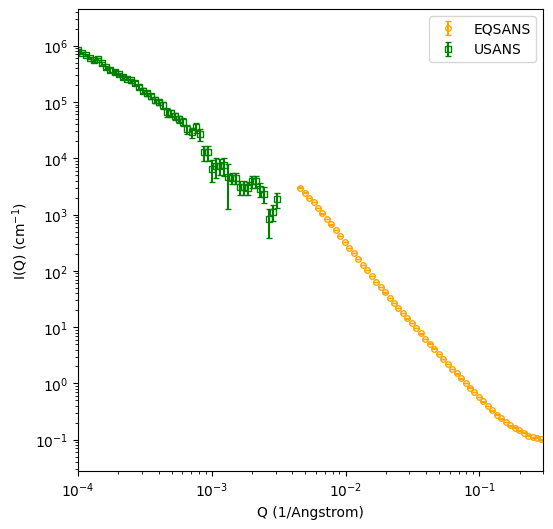

In [4]:
index = "3825"
filename_eq = f"./data/tz_SANS_USANS_data/data/{index}_8_dry.dat"
data_eq = np.loadtxt(filename_eq, skiprows=12)
Q_eq = data_eq[:, 0]
I_eq = data_eq[:, 1]
delta_I_eq = data_eq[:, 2]
delta_Q_eq = data_eq[:, 3]
bg_eq = 0.297
# I_eq -= bg_eq

filename_USANS = f"./data/tz_SANS_USANS_data/data/UN_X{index}_det_1_lbs.txt"
data_USANS = np.loadtxt(filename_USANS, delimiter='\t', dtype=float, usecols=(0, 1, 2))
Q_usans = data_USANS[:, 0]
I_usans = data_USANS[:, 1]
delta_I_usans = data_USANS[:, 2]


# plot the data to verify loading
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.errorbar(Q_eq, I_eq, yerr=delta_I_eq, fmt='o', markersize=4, label='EQSANS', fillstyle='none', capsize=2, color='orange')
# ax.errorbar(Q_usans_para, I_usans_para, yerr=delta_I_usans_para, fmt='^', markersize=4, label='USANS Para', fillstyle='none', capsize=2)
# ax.errorbar(Q_usans_perp, I_usans_perp, yerr=delta_I_usans_perp, fmt='v', markersize=4, label='USANS Perp', fillstyle='none', capsize=2)
ax.errorbar(Q_usans, I_usans, yerr=delta_I_usans, fmt='s', markersize=4, label='USANS', fillstyle='none', capsize=2, color='green')
ax.legend()
ax.set_xlim(1e-4, 3e-1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Q (1/Angstrom)')
ax.set_ylabel('I(Q) (cm$^{-1}$)')

In [8]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.stats import linregress
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar

import numpy as np
from scipy.stats import linregress
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar

def prepare_equsans_usans_cat(Q_eq, I_eq, delta_I_eq,
                              Q_usans, I_usans, delta_I_usans,
                              psf,
                              optimize_sigma_y=False,
                              sigma_y_opt=None,
                              sigma_y_bounds=(1e-2, 1e1),
                              Q_usans_match_min=1e-3,
                              n_Q_gap=5,
                              n_Q_eq_extrap_log=500,
                              Q_cat_log_min=5e-5,
                              n_Q_cat=64,
                              Q_cat_max=None):
    """
    Preprocess EQSANS + USANS data:
    - Extrapolate EQSANS into overlap region
    - Smear EQSANS using a user-supplied PSF   <-- (NEW)
    - Propagate errors
    - Concatenate EQSANS + USANS
    - Interpolate onto log-uniform Q grid for GPR

    Parameters
    ----------
    psf : callable
        psf(sigma_y, Q_obs, Q_latent) -> R matrix
        (user-defined PSF including trapezoidal weights)

    Q_eq, I_eq, delta_I_eq : array_like
        EQSANS Q, intensity, and error.
    Q_usans, I_usans, delta_I_usans : array_like
        USANS Q, intensity, and error.
    optimize_sigma_y : bool, optional
        If True, choose sigma_y_opt by minimizing chi^2 between smeared EQSANS
        and USANS in the overlap. If False, use `sigma_y_opt` if given, else 0.24.
    sigma_y_opt : float or None, optional
        Manually specified sigma_y. Used when optimize_sigma_y is False or as
        initial guess; if None and optimize_sigma_y=False, defaults to 0.24.
    sigma_y_bounds : tuple, optional
        Bounds for sigma_y optimization (min, max).
    Q_usans_match_min : float, optional
        Minimum Q in USANS data to use for overlap region with EQSANS extrapolation.
    n_Q_gap : int, optional
        Number of points in the Q-gap between USANS and EQSANS for extrapolated line.
    n_Q_eq_extrap_log : int, optional
        Number of log-spaced points for extrapolated EQSANS intensity.
    Q_cat_log_min : float, optional
        Minimum Q for the final log-spaced concatenated grid.
    n_Q_cat : int, optional
        Number of points in the final log-spaced concatenated grid.
    Q_cat_max : float or None, optional
        Maximum Q for the final log-spaced concatenated grid.

    Returns
    -------
    Q_cat : ndarray
        Log-uniform concatenated Q grid.
    I_cat : ndarray
        Concatenated intensity on Q_cat.
    delta_I_cat : ndarray
        Concatenated uncertainties on Q_cat.
    sigma_y_opt : float
        Resolution width used for smearing.
    """

    Q_eq = np.asarray(Q_eq)
    I_eq = np.asarray(I_eq)
    delta_I_eq = np.asarray(delta_I_eq)

    Q_usans = np.asarray(Q_usans)
    I_usans = np.asarray(I_usans)
    delta_I_usans = np.asarray(delta_I_usans)

    # ------------------------------------------------------------------
    # 1. Fit EQSANS log–log linear region
    # ------------------------------------------------------------------
    log_Q_eq = np.log10(Q_eq)
    log_I_eq = np.log10(I_eq)
    mask = (Q_eq >= 2e-3) & (Q_eq <= 2e-2)

    slope, intercept, *_ = linregress(log_Q_eq[mask], log_I_eq[mask])

    # extrapolate into USANS region
    Q_usans_mask = Q_usans >= Q_usans_match_min
    I_eq_extrap_overlap = 10**(intercept + slope * np.log10(Q_usans[Q_usans_mask]))

    # Q-gap between USANS and EQSANS
    Q_gap = np.logspace(np.log10(Q_usans[-1]), np.log10(Q_eq[0]), n_Q_gap, endpoint=False)
    I_gap = 10**(intercept + slope * np.log10(Q_gap))

    # full extrapolated EQSANS curve
    Q_eq_extrap = np.concatenate([Q_usans[Q_usans_mask], Q_gap, Q_eq])
    I_eq_extrap = np.concatenate([I_eq_extrap_overlap, I_gap, I_eq])

    # ------------------------------------------------------------------
    # 2. Interpolate EQ extrapolation onto log grid
    # ------------------------------------------------------------------
    Q_eq_extrap_log = np.logspace(np.log10(Q_eq_extrap[0]),
                                  np.log10(Q_eq_extrap[-1]),
                                  n_Q_eq_extrap_log)

    f_interp_eq = interp1d(Q_eq_extrap, I_eq_extrap, kind='linear', fill_value='extrapolate')
    I_eq_extrap_log = f_interp_eq(Q_eq_extrap_log)

    # ------------------------------------------------------------------
    # 3. Optionally optimize sigma_y via chi^2
    # ------------------------------------------------------------------
    def f_I_sm(sigma_y):
        R_mat = psf(sigma_y, Q_usans[Q_usans_mask], Q_eq_extrap_log)
        return R_mat @ I_eq_extrap_log

    if optimize_sigma_y:
        def chi2(sy):
            I_sm = f_I_sm(sy)
            res = (I_sm - I_usans[Q_usans_mask]) / delta_I_usans[Q_usans_mask]
            return np.sum(res**2)

        res = minimize_scalar(chi2, bounds=sigma_y_bounds, method='bounded')
        sigma_y_opt_used = res.x
    else:
        sigma_y_opt_used = 0.24 if sigma_y_opt is None else float(sigma_y_opt)

    # ------------------------------------------------------------------
    # 4. Smear EQSANS with user PSF and propagate error
    # ------------------------------------------------------------------
    R_eq = psf(sigma_y_opt_used, Q_eq, Q_eq_extrap_log)
    I_eq_smeared = R_eq @ I_eq_extrap_log

    # propagate uncertainties
    delta_I_eq_smeared = np.sqrt(np.sum((R_eq * delta_I_eq[:,None])**2, axis=1))

    # ------------------------------------------------------------------
    # 5. Concatenate USANS and smeared EQSANS
    # ------------------------------------------------------------------   
    Q_cat_raw = np.concatenate([Q_usans, Q_eq])
    I_cat_raw = np.concatenate([I_usans, I_eq_smeared])
    delta_I_cat_raw = np.concatenate([delta_I_usans, delta_I_eq_smeared])

    # ------------------------------------------------------------------
    # 6. Interpolate onto final log-uniform Q grid for GPR
    # ------------------------------------------------------------------
    if Q_cat_max is None:
        Q_cat_max = Q_cat_raw[-1]
    Q_cat = np.logspace(np.log10(Q_cat_log_min), np.log10(Q_cat_max), n_Q_cat)

    interp_I = interp1d(Q_cat_raw, I_cat_raw, kind='linear', fill_value='extrapolate')
    interp_dI = interp1d(Q_cat_raw, delta_I_cat_raw, kind='linear', fill_value='extrapolate')

    I_cat = interp_I(Q_cat)
    delta_I_cat = interp_dI(Q_cat)

    return Q_cat, I_cat, delta_I_cat, sigma_y_opt_used, Q_eq_extrap, I_eq_extrap


## function for GPR inversion from concatenated data
def gpr_inversion_linear_operator(Q_cat, I_cat, delta_I_cat,
                                  sigma_y_opt,
                                  psf_func,
                                  lmbda_factor=10.0,
                                  smooth_sigma=2.0,
                                  prior_mean_user=None,
                                  log_c_min=-4.0,
                                  log_c_max=4.0,
                                  n_log_c=121,
                                  c_user=None,
                                  sigma_low=None):
    """
    GPR inversion with linear resolution operator and prior mean.
    Includes optional user-specified GP amplitude c_user.
    
    -----------------------------------------------------------------------
    USAGE EXAMPLES
    -----------------------------------------------------------------------

    # 1) FULL GP INVERSION WITH AUTOMATIC OPTIMIZATION OF AMPLITUDE c
    I_post, I_std, I_smr, I_prior, I_prior_smr, c_opt, Cov_f, K_cat = \
        gpr_inversion_linear_operator(
            Q_cat, I_cat, delta_I_cat,
            sigma_y_opt,
            psf_func
        )
    # -> c_opt is chosen by maximizing GP marginal likelihood.

    # 2) USE A USER-SPECIFIED AMPLITUDE (SKIP OPTIMIZATION)
    I_post, I_std, I_smr, I_prior, I_prior_smr, c_used, Cov_f, K_cat = \
        gpr_inversion_linear_operator(
            Q_cat, I_cat, delta_I_cat,
            sigma_y_opt,
            psf_func,
            c_user = 0.3     # user defines the GP strength
        )
    # -> c_used = 0.3 and no marginal-likelihood search is performed.

    Parameters
    ----------
    Q_cat, I_cat, delta_I_cat : arrays
        Input Q-grid, intensity, and uncertainty.
    sigma_y_opt : float
        Resolution width passed to psf_func.
    psf_func : callable
        Function psf_func(sigma_y, Q_obs, Q_latent) -> R matrix.
    lmbda_factor : float
        Factor for log-Q correlation length.
    smooth_sigma : float
        Smoothing sigma for constructing I_prior.
    prior_mean_user : array
        If provided, override the automatically generated prior
    log_c_min, log_c_max : float
        Search range for log c when c_user is None.
    n_log_c : int
        Number of grid points in c search.
    c_user : float or None
        If provided, overrides optimization and sets amplitude manually.
    sigma_low : float
        If provided, overrides the prior standard deviation (1) at the lowest Q.

    Returns
    -------
    I_post, I_post_std : arrays
        Posterior mean and standard deviation (latent space).
    I_post_smeared : array
        Posterior mapped through resolution operator. (for comparison to data)
    I_prior : array
        Prior mean.
    c_opt : float
        Optimal or user-supplied amplitude.
    Cov_f : array
        Posterior covariance.
    K_cat : array
        Final prior covariance.
    """

    Q_cat = np.asarray(Q_cat)
    I_cat = np.asarray(I_cat)
    delta_I_cat = np.asarray(delta_I_cat)

    N_cat = Q_cat.size

    # ---------- PRIOR MEAN ----------
    I_cat_sm = gaussian_filter1d(I_cat, sigma=smooth_sigma)
    R_cat = psf_func(sigma_y_opt, Q_cat, Q_cat)
    pinv_R_sm_cat = np.linalg.pinv(R_cat)
    I_prior = pinv_R_sm_cat @ I_cat_sm
    I_prior_sm = R_cat @ I_prior
    
    if prior_mean_user is not None:
        I_prior = prior_mean_user
        I_prior_sm = R_cat @ I_prior

    # ---------- GP PRIOR COVARIANCE (BASE) ----------
    Q_cat_min, Q_cat_max = Q_cat.min(), Q_cat.max()
    lmbda = np.log(Q_cat_max / Q_cat_min) / N_cat * lmbda_factor
    logQ_cat = np.log(Q_cat)

    # base kernel (unit variance)
    K_base = np.exp(-(logQ_cat[:, None] - logQ_cat[None, :])**2 / (2 * lmbda**2))
    K_cat = K_base.copy()
    
    # non-stationary covariance
    if sigma_low is not None:
        # ---- non-stationary amplitude: smaller variance at low Q ----
        # map logQ in [0,1]
        t = (logQ_cat - np.log(Q_cat_min)) / (np.log(Q_cat_max) - np.log(Q_cat_min))
        t = np.clip(t, 0.0, 1.0)

        # choose variances: very confident at low Q, more flexible at high Q
        sigma_high = 1.0   # prior std at highest Q
        p = 2.0            # shape parameter: >1 makes transition sharper

        sigma_prior = sigma_low + (sigma_high - sigma_low) * (t**p)
        K_cat = (sigma_prior[:, None] * sigma_prior[None, :]) * K_base

    # ---------- NOISE AND RESIDUAL ----------
    Sigma = np.diag(delta_I_cat**2)
    residual = I_cat - (R_cat @ I_prior)

    # ---------- OPTION A: user-specified amplitude ----------
    if c_user is not None:
        c_opt = float(c_user)

    # ---------- OPTION B: optimize amplitude ----------
    else:
        def log_marginal_likelihood(log_c):
            c = np.exp(log_c)
            K_cat_local = (c**2) * K_base
            Ky_local = K_cat_local @ R_cat.T
            Kyy_local = R_cat @ K_cat_local @ R_cat.T + Sigma

            # Cholesky log-likelihood
            try:
                L = np.linalg.cholesky(Kyy_local)
            except np.linalg.LinAlgError:
                jitter = 1e-12 * np.eye(N_cat)
                L = np.linalg.cholesky(Kyy_local + jitter)
                Kyy_local += jitter

            alpha = np.linalg.solve(L.T, np.linalg.solve(L, residual))
            return (
                -0.5 * residual @ alpha
                - np.sum(np.log(np.diag(L)))
                - 0.5 * N_cat * np.log(2 * np.pi)
            )

        log_c_grid = np.linspace(log_c_min, log_c_max, n_log_c)
        log_ml_vals = np.array([log_marginal_likelihood(lc) for lc in log_c_grid])
        log_c_opt = log_c_grid[np.argmax(log_ml_vals)]
        c_opt = np.exp(log_c_opt)

    # ---------- POSTERIOR WITH CHOSEN AMPLITUDE ----------
    K_cat = (c_opt**2) * K_cat

    Ky = K_cat @ R_cat.T
    Kyy = R_cat @ K_cat @ R_cat.T + Sigma

    I_post = I_prior + Ky @ np.linalg.solve(Kyy, residual)

    Kyy_inv = np.linalg.solve(Kyy, np.eye(N_cat))
    Cov_f = K_cat - Ky @ Kyy_inv @ Ky.T

    I_post_std = np.sqrt(np.diag(Cov_f))
    I_post_smeared = R_cat @ I_post

    return I_post, I_post_std, I_post_smeared, I_prior, I_prior_sm, c_opt, Cov_f, K_cat

# log space variant of GPR inversion
def gpr_inversion_linear_operator_log(Q_cat, I_cat, delta_I_cat,
                                      sigma_y_opt,
                                      psf_func,
                                      lmbda_factor=10.0,
                                      smooth_sigma=2.0,
                                      prior_mean_user=None,
                                      log_c_min=-4.0,
                                      log_c_max=4.0,
                                      n_log_c=81,
                                      c_user=None,
                                      sigma_low=None):
    """
    GPR inversion with linear resolution operator and prior mean,
    using a *log-intensity likelihood* (approximate Poisson -> Gaussian in log I).

    Model:
        I(Q) ~ GP prior in linear intensity space
        y_i = log(I_i^Exp)  (observed)
        y_i ≈ log( (R I_prior)_i ) + J_i · (I - I_prior) + ε_i
        ε ~ N(0, Σ_log)

    where J = diag(1 / (R I_prior)) @ R is the Jacobian of log(R I) w.r.t. I,
    giving a linearized observation model suitable for GP inference.

    Parameters
    ----------
    Q_cat, I_cat, delta_I_cat : arrays
        Input Q-grid, intensity, and uncertainty (linear intensity).
    sigma_y_opt : float
        Resolution width passed to psf_func.
    psf_func : callable
        Function psf_func(sigma_y, Q_obs, Q_latent) -> R matrix.
    lmbda_factor : float
        Factor for log-Q correlation length in the GP kernel.
    smooth_sigma : float
        Gaussian smoothing sigma (in Q index) for constructing I_prior.
    prior_mean_user : array
        If provided, override the automatically generated prior
    log_c_min, log_c_max : float
        Search range for log c when c_user is None.
    n_log_c : int
        Number of grid points in c search.
    c_user : float or None
        If provided, overrides optimization and sets amplitude manually.
    sigma_low : float
        If provided, overrides the prior standard deviation (1) at the lowest Q.

    Returns
    -------
    I_post : array
        Posterior mean of intensity I(Q) in latent space.
    I_post_std : array
        Posterior standard deviation of intensity.
    I_post_smeared : array
        Posterior mean mapped through the resolution operator R.
    I_prior : array
        Prior mean in intensity space.
    I_prior_sm : array
        Prior mean mapped to observation space.
    c_opt : float
        Optimal or user-supplied amplitude of the GP prior.
    Cov_f : array
        Posterior covariance of intensity I(Q).
    K_cat : array
        Prior covariance (in intensity space) with optimized amplitude.
    """

    Q_cat = np.asarray(Q_cat)
    I_cat = np.asarray(I_cat)
    delta_I_cat = np.asarray(delta_I_cat)

    N_cat = Q_cat.size

    # ---------- PRIOR MEAN IN INTENSITY SPACE ----------
    I_cat_sm = gaussian_filter1d(I_cat, sigma=smooth_sigma)
    R_cat = psf_func(sigma_y_opt, Q_cat, Q_cat)
    # Add regularization to the inversion process
    regularization_strength = 1e-18  # Regularization parameter
    identity_matrix = np.eye(R_cat.shape[1])
    pinv_R_sm_cat = np.linalg.pinv(R_cat.T @ R_cat + regularization_strength * identity_matrix) @ R_cat.T
    I_prior = pinv_R_sm_cat @ I_cat_sm
    I_prior_sm = R_cat @ I_prior
    
    if prior_mean_user is not None:
        I_prior = prior_mean_user
        I_prior_sm = R_cat @ I_prior

    # ---------- TRANSFORM DATA TO LOG-SPACE (LIKELIHOOD) ----------
    eps = 1e-16  # avoid log(0)
    I_safe = np.maximum(I_cat, eps)
    y_log = np.log(I_safe)

    # prior prediction in observation space and its log
    mu_prior = np.maximum(I_prior_sm, eps)
    mu_log = np.log(mu_prior)

    # residual in log space
    residual_log = y_log - mu_log

    # approximate noise variance in log-space: Var[log I] ≈ Var[I] / I^2
    delta_logI_cat = delta_I_cat / I_safe
    Sigma_log = np.diag(delta_logI_cat**2)

    # ---------- LINEARIZED FORWARD OPERATOR IN LOG-LIKELIHOOD ----------
    # log(R I) ≈ log(R I_prior) + diag(1 / (R I_prior)) @ R (I - I_prior)
    J = (1.0 / mu_prior)[:, None] * R_cat  # shape (M, L), Jacobian
    A = J  # effective linear operator from δI to log-domain residual

    # ---------- GP PRIOR COVARIANCE (BASE) ON δI (INTENSITY) ----------
    Q_cat_min, Q_cat_max = Q_cat.min(), Q_cat.max()
    lmbda = np.log(Q_cat_max / Q_cat_min) / N_cat * lmbda_factor
    logQ_cat = np.log(Q_cat)

    K_base = np.exp(-(logQ_cat[:, None] - logQ_cat[None, :])**2 / (2 * lmbda**2))
    K_cat = K_base.copy()

    # non-stationary covariance
    if sigma_low is not None:
        # ---- non-stationary amplitude: smaller variance at low Q ----
        # map logQ in [0,1]
        t = (logQ_cat - np.log(Q_cat_min)) / (np.log(Q_cat_max) - np.log(Q_cat_min))
        t = np.clip(t, 0.0, 1.0)

        # choose variances: very confident at low Q, more flexible at high Q
        sigma_high = 1.0   # prior std at highest Q
        p = 2.0            # shape parameter: >1 makes transition sharper

        sigma_prior = sigma_low + (sigma_high - sigma_low) * (t**p)
        K_cat = (sigma_prior[:, None] * sigma_prior[None, :]) * K_base

    # ---------- OPTION A: user-specified amplitude ----------
    if c_user is not None:
        c_opt = float(c_user)

    # ---------- OPTION B: optimize amplitude via log-likelihood in log-space ----------
    else:
        def log_marginal_likelihood(log_c):
            c = np.exp(log_c)
            K_cat_local = (c**2) * K_base
            Ky_local = K_cat_local @ A.T
            Kyy_local = A @ K_cat_local @ A.T + Sigma_log

            try:
                L = np.linalg.cholesky(Kyy_local)
            except np.linalg.LinAlgError:
                jitter = 1e-12 * np.eye(N_cat)
                L = np.linalg.cholesky(Kyy_local + jitter)
                Kyy_local += jitter

            alpha = np.linalg.solve(L.T, np.linalg.solve(L, residual_log))
            return (
                -0.5 * residual_log @ alpha
                - np.sum(np.log(np.diag(L)))
                - 0.5 * N_cat * np.log(2 * np.pi)
            )

        log_c_grid = np.linspace(log_c_min, log_c_max, n_log_c)
        log_ml_vals = np.array([log_marginal_likelihood(lc) for lc in log_c_grid])
        log_c_opt = log_c_grid[np.argmax(log_ml_vals)]
        c_opt = np.exp(log_c_opt)

    # ---------- POSTERIOR ON δI WITH CHOSEN AMPLITUDE ----------
    K_cat = (c_opt**2) * K_cat

    Ky = K_cat @ A.T
    Kyy = A @ K_cat @ A.T + Sigma_log

    delta_I_post = Ky @ np.linalg.solve(Kyy, residual_log)
    I_post = I_prior + delta_I_post

    # posterior covariance of δI
    Kyy_inv = np.linalg.solve(Kyy, np.eye(N_cat))
    Cov_f = K_cat - Ky @ Kyy_inv @ Ky.T

    I_post_std = np.sqrt(np.diag(Cov_f))
    I_post_smeared = R_cat @ I_post

    return I_post, I_post_std, I_post_smeared, I_prior, I_prior_sm, c_opt, Cov_f, K_cat


Optimal sigma_y: 2.4837e-02 1/Angstrom


Text(0, 0.5, 'I(Q) (cm$^{-1}$)')

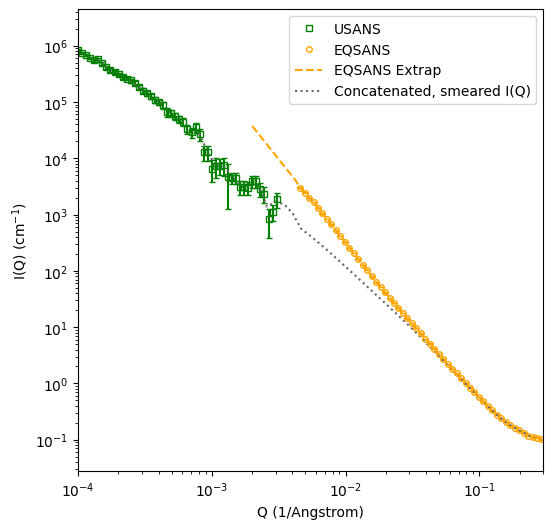

In [81]:
# step 1: define the PSF function
def f_R(Q1, Q2, sigma_y):
    R_mat = R_rect(Q1, Q2, sigma_x=sigma_y*1e-7, sigma_y=sigma_y, nx=4, quad='trapz')
    return R_mat

def psf(sigma_y, Q, Q_prime):
    # build the psf according to given sigma_y and Q grids
    R_raw = f_R(Q, Q_prime, sigma_y)
    # Compute trapezoidal integration weights for Q_model
    w_model = np.zeros_like(Q_prime)
    w_model[1:-1] = 0.5 * (Q_prime[2:] - Q_prime[:-2])
    w_model[0] = 0.5 * (Q_prime[1] - Q_prime[0])
    w_model[-1] = 0.5 * (Q_prime[-1] - Q_prime[-2])

    # Compute the weighted kernel (numerator of the integral ∫ R I dQ')
    num = R_raw * w_model[None, :]

    # Normalize rows of the resolution matrix so each PSF integrates to 1
    row_sum = num.sum(axis=1, keepdims=True)
    R_mat = num / row_sum
    
    return R_mat

# step 2: prepare the concatenated data
Q_cat, I_cat, delta_I_cat, sigma_y_opt, Q_eq_extrap, I_eq_extrap = prepare_equsans_usans_cat(
    Q_eq, I_eq, delta_I_eq,
    Q_usans, I_usans, delta_I_usans,
    psf,
    optimize_sigma_y=True,
    # sigma_y_opt=0.24,
    Q_usans_match_min=2e-3,
    Q_cat_max=0.5,
    n_Q_cat=64
)
print(f"Optimal sigma_y: {sigma_y_opt:.4e} 1/Angstrom")

# plot the data to verify loading
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
handles = []
labels  = []

# USANS
h = ax.errorbar(Q_usans, I_usans, yerr=delta_I_usans,
                 fmt='s', markersize=4, fillstyle='none',
                 capsize=2, color='green')[0]
handles.append(h); labels.append('USANS')

# EQSANS
h = ax.errorbar(Q_eq, I_eq, yerr=delta_I_eq,
                 fmt='o', markersize=4, fillstyle='none',
                 capsize=2, color='orange')[0]
handles.append(h); labels.append('EQSANS')

# Extrapolated EQSANS
h, = ax.plot(Q_eq_extrap, I_eq_extrap, '--', color='orange')
handles.append(h); labels.append('EQSANS Extrap')

# Concatenated smeared data
# h = ax.errorbar(Q_cat, I_cat, yerr=delta_I_cat,
#                  fmt=':', markersize=4, fillstyle='none',
#                  capsize=2, color='#666666')[0]
h, = ax.plot(Q_cat, I_cat, ':', color='#666666')
handles.append(h); labels.append('Concatenated, smeared I(Q)')

ax.legend(handles, labels)

ax.set_xlim(1e-4, 3e-1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Q (1/Angstrom)')
ax.set_ylabel('I(Q) (cm$^{-1}$)')

/tmp/ipykernel_61461/108959182.py:509: RuntimeWarning: invalid value encountered in sqrt
  I_post_std = np.sqrt(np.diag(Cov_f))


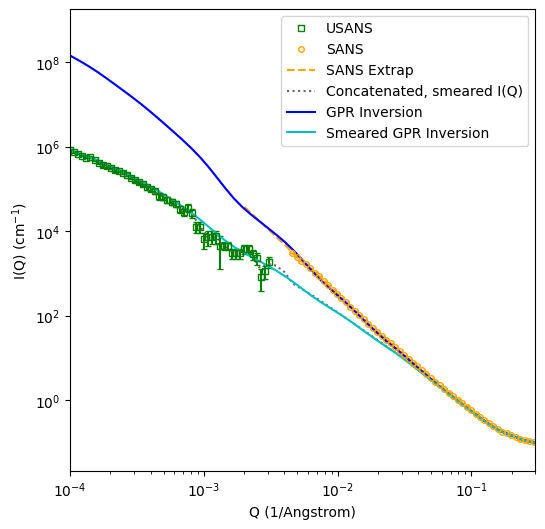

In [86]:

# step 3: GPR inversion
I_post, I_post_std, I_post_smeared, I_prior, I_prior_sm, c_opt, Cov_f, K_cat = gpr_inversion_linear_operator_log(
            Q_cat, I_cat, delta_I_cat,
            sigma_y_opt,
            psf,
            lmbda_factor=5.0,
            c_user=20,
        )

# plot the data to verify loading
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
handles = []
labels  = []

# USANS
h = ax.errorbar(Q_usans, I_usans, yerr=delta_I_usans,
                 fmt='s', markersize=4, fillstyle='none',
                 capsize=2, color='green')[0]
handles.append(h); labels.append('USANS')

# EQSANS
h = ax.errorbar(Q_eq, I_eq, yerr=delta_I_eq,
                 fmt='o', markersize=4, fillstyle='none',
                 capsize=2, color='orange')[0]
handles.append(h); labels.append('SANS')

# Extrapolated EQSANS
h, = ax.plot(Q_eq_extrap, I_eq_extrap, '--', color='orange')
handles.append(h); labels.append('SANS Extrap')

# Concatenated smeared data
# h = ax.errorbar(Q_cat, I_cat, yerr=delta_I_cat,
#                  fmt=':', markersize=4, fillstyle='none',
#                  capsize=2, color='#666666')[0]
h, = ax.plot(Q_cat, I_cat, ':', color='#666666')
handles.append(h); labels.append('Concatenated, smeared I(Q)')

# GPR posterior
h, = ax.plot(Q_cat, I_post, 'b-')
handles.append(h); labels.append('GPR Inversion')

# Uncertainty band
fb = ax.fill_between(Q_cat, I_post - I_post_std, I_post + I_post_std,
                     color='b', alpha=0.3)
# handles.append(fb); labels.append('GPR Uncertainty')

# Smeared GPR
h, = ax.plot(Q_cat, I_post_smeared, 'c-')
handles.append(h); labels.append('Smeared GPR Inversion')

ax.legend(handles, labels)

ax.set_xlim(1e-4, 3e-1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Q (1/Angstrom)')
ax.set_ylabel('I(Q) (cm$^{-1}$)')

# save plotting data in .json format
import json
plot_data = {
    # usans
    'Q_usans': Q_usans.tolist(),
    'I_usans': I_usans.tolist(),
    'delta_I_usans': delta_I_usans.tolist(),
    # eqsans
    'Q_eq': Q_eq.tolist(),
    'I_eq': I_eq.tolist(),
    'delta_I_eq': delta_I_eq.tolist(),
    # eqsans extrapolation
    'Q_eq_extrap': Q_eq_extrap.tolist(),
    'I_eq_extrap': I_eq_extrap.tolist(),
    # concatenated data
    'Q_cat': Q_cat.tolist(),
    'I_cat': I_cat.tolist(),
    'delta_I_cat': delta_I_cat.tolist(),
    # GPR posterior
    'I_post': I_post.tolist(),
    'I_post_std': I_post_std.tolist(),
    'I_post_smeared': I_post_smeared.tolist(),
    'I_prior': I_prior.tolist(),
    'I_prior_sm': I_prior_sm.tolist(),
    'c_opt': c_opt,
    'sigma_y_opt': sigma_y_opt,
}
with open('desmear_exp_tz2.json', 'w') as f:
    json.dump(plot_data, f, indent=4)

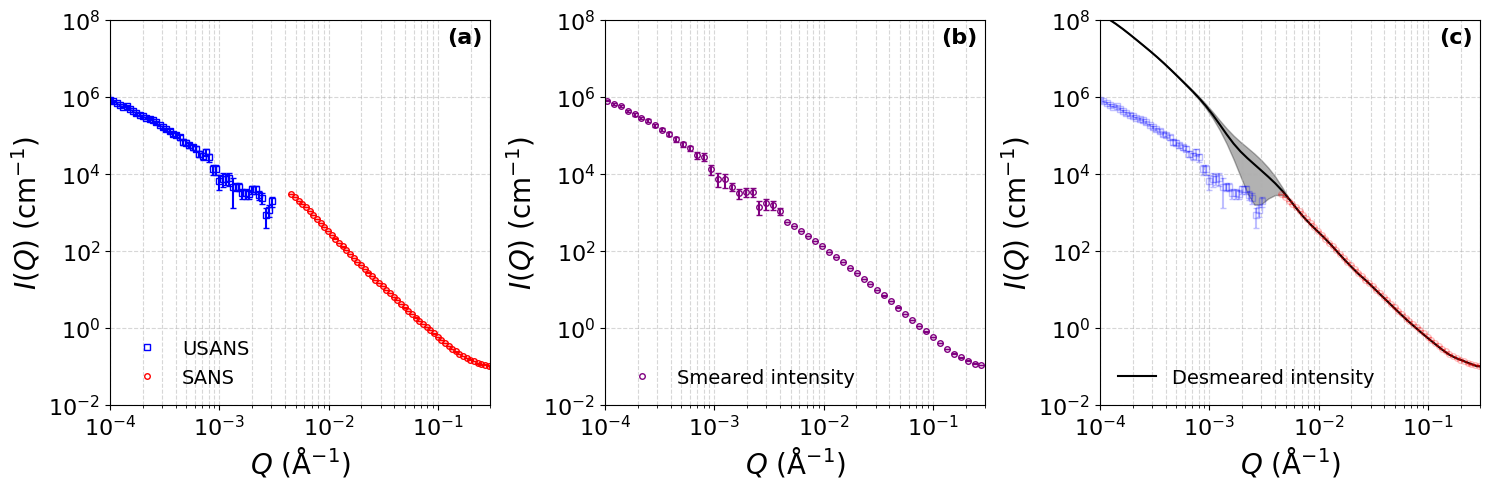

In [101]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
panel_labels = ['(a)', '(b)', '(c)']
for ax, label in zip(axs, panel_labels):
    ax.text(0.98, 0.98, label, transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

ax = axs[0]

handles = []
labels  = []
# USANS
h = ax.errorbar(Q_usans, I_usans, yerr=delta_I_usans,
                 fmt='s', markersize=4, fillstyle='none',
                 capsize=2, color='blue')[0]
handles.append(h); labels.append('USANS')

# EQSANS
h = ax.errorbar(Q_eq, I_eq, yerr=delta_I_eq,
                 fmt='o', markersize=4, fillstyle='none',
                 capsize=2, color='red')[0]
handles.append(h); labels.append('SANS')

ax.legend(handles, labels, fontsize=14, frameon=False, loc='lower left')

ax.set_xlim(1e-4, 3e-1)
ax.set_ylim(1e-2, 1e8)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"$Q$ (Å$^{-1}$)", fontsize=20)
ax.set_ylabel(r"$I(Q)$ (cm$^{-1}$)", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.grid(True, which='both', ls='--', alpha=0.5)

ax = axs[1]
handles = []
labels  = []
# Concatenated smeared data
h = ax.errorbar(Q_cat, I_cat, yerr=delta_I_cat,
                 linestyle='', marker='o', markersize=4, fillstyle='none',
                 capsize=2, color='purple')[0]
handles.append(h); labels.append('Smeared intensity')

ax.legend(handles, labels, fontsize=14, frameon=False, loc='lower left')

ax.set_xlim(1e-4, 3e-1)
ax.set_ylim(1e-2, 1e8)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"$Q$ (Å$^{-1}$)", fontsize=20)
ax.set_ylabel(r"$I(Q)$ (cm$^{-1}$)", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.grid(True, which='both', ls='--', alpha=0.5)

ax = axs[2]
handles = []
labels  = []
# GPR posterior
h, = ax.plot(Q_cat, I_post, 'k-')
handles.append(h); labels.append('Desmeared intensity')

# Uncertainty band
# fb = ax.fill_between(Q_cat, I_post - I_post_std, I_post + I_post_std,
#                      color='k', alpha=0.3)
# estimate uncertainty band using propagated error from concatenated data I_cat, delta_I_cat and the resolution function, since the GPR uncertainty may be underestimated due to model mismatch
R_cat = psf(sigma_y_opt, Q_cat, Q_cat)
R = R_cat
y = np.asarray(I_cat, dtype=float)
sig = np.asarray(delta_I_cat, dtype=float)

N = y.size
W = 1.0 / np.maximum(sig, 1e-300)**2  # weights as a vector

# Choose a regularizer L. Common choice: 2nd-difference for smoothness.
# L has shape ((N-2), N)
L = np.zeros((N-2, N))
for i in range(N-2):
    L[i, i]   = 1.0
    L[i, i+1] = -2.0
    L[i, i+2] = 1.0

lam = 1e-2  # <-- set from your procedure (CV, L-curve, etc.)

# Build normal matrix K = R^T W R + lam L^T L
# Use W as a diagonal (vector) to avoid forming huge diag matrices.
RW = R * W[None, :]          # each column j scaled by W_j (since (R I - y)_j weighted)
K = R.T @ RW + lam * (L.T @ L)

# Right-hand side b = R^T W y
b = R.T @ (W * y)

# Desmeared estimate
I_hat = np.linalg.solve(K, b)

# Propagated covariance: Σ_hat = A Σ_obs A^T
# We can compute A without explicitly inverting K:
# A = K^{-1} R^T W.  Let B = R^T W (shape N x N). Then A = solve(K, B).
B = R.T * W[None, :]         # column j scaled by W_j
A = np.linalg.solve(K, B)    # A is N x N (dense)

Sigma_hat = A @ ( (sig**2)[:, None] * A.T )  # A Σ_obs A^T, using Σ_obs diagonal
I_std_desmeared = np.sqrt(np.clip(np.diag(Sigma_hat), 0.0, np.inf))

fb = ax.fill_between(Q_cat, I_post - I_std_desmeared, I_post + I_std_desmeared,
                     color='k', alpha=0.3)
# USANS
h = ax.errorbar(Q_usans, I_usans, yerr=delta_I_usans,
                 fmt='s', markersize=4, fillstyle='none',
                 capsize=2, color='blue', alpha=0.25)[0]
# handles.append(h); labels.append('USANS')

# EQSANS
h = ax.errorbar(Q_eq, I_eq, yerr=delta_I_eq,
                 fmt='o', markersize=4, fillstyle='none',
                 capsize=2, color='red', alpha=0.25)[0]
# handles.append(h); labels.append('SANS')

ax.legend(handles, labels, fontsize=14, frameon=False, loc='lower left')

ax.set_xlim(1e-4, 3e-1)
ax.set_ylim(1e-2, 1e8)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"$Q$ (Å$^{-1}$)", fontsize=20)
ax.set_ylabel(r"$I(Q)$ (cm$^{-1}$)", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.grid(True, which='both', ls='--', alpha=0.5)
plt.tight_layout()